In [90]:
from autograd import grad
import autograd.numpy as np

# PARAMS

In [91]:
# select x and y randomly between 0 and 3 inclusive upto 5 decimal place
x, y = 5.0, 5.0
xlims, ylims = [-10, 10], [-10, 10]
lr = 0.05
equation = 2
iter = 1000

# Loss Functions

In [92]:
# F = lambda x: -3*(x+np.pi/2) if x <= -np.pi/2 else -3*np.cos(x) if -np.pi/2 < x <= np.pi/2 else -np.cos(x) + 2*x - np.pi
# F = lambda x: np.piecewise(x, [x <= -np.pi/2, (-np.pi/2 < x) and (x <= np.pi/2), x > np.pi/2],
#                         [lambda x: -3*(x+np.pi/2), lambda x: -3*np.cos(x), lambda x: -np.cos(x) + 2*x - np.pi])

if equation == 0:
    loss_function = lambda x, y: -3*x*x - y*y + 4*x*y
elif equation == 1:
    loss_function = lambda x, y: 3*x*x + y*y + 4*x*y
elif equation == 2:
    loss_function = lambda x, y: (4*x*x - (y-3*x+0.05*x**3)**2 - 0.1*y**4)*np.exp(-0.01*(x**2+y**2))
elif equation == 3:
    loss_function = lambda x, y: ((0.3*x*x + y)**2 + (0.1*y*y + x)**2)*np.exp(-0.01*(x**2+y**2))
elif equation == 4:
    loss_function = lambda x, y: np.log(1+np.exp(x)) + 3*x*y - np.log(1+np.exp(y))
# elif equation == 5:
#     loss_function = lambda x, y: F(x) + 3*x*y - F(y)

# Gradient Descent Ascent

In [93]:
gda_vals = [[x, y, loss_function(x, y)]]
def GDA(x, y, lr):
    print('Gradient Descent Ascent: ')
    for c in range(iter):
        x = x - lr * grad(loss_function, 0)(x, y)
        y = y + lr * grad(loss_function, 1)(x, y)
        z = loss_function(x, y)
        
        gda_vals.append([x, y, z])

# Optimistic GDA

In [94]:
ogda_vals = [[x, y, loss_function(x, y)]]
def OGDA(x, y, lr):
    print('Optimistic Gradient Descent Ascent: ')
    x0, y0, x1, y1 = x, y, x-lr, y+lr
    for c in range(iter):
        grad_f = grad(loss_function, (0, 1))
        grad_x0, grad_y0 = grad_f(x0, y0)
        grad_x1, grad_y1 = grad_f(x1, y1)

        x_new = x1 - 2*lr*grad_x1 + lr*grad_x0
        y_new = y1 + 2*lr*grad_y1 - lr*grad_y0

        x0, y0, x1, y1 = x1, y1, x_new, y_new
        z = loss_function(x1, y1)
        ogda_vals.append([x1, y1, z])

# Extragradient

In [95]:
eg_vals = [[x, y, loss_function(x, y)]]
def EG(x, y, lr):
    print('Extragradient: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0, 1))
        grad_x, grad_y = grad_f(x, y)

        x_temp = x - lr*grad_x
        y_temp = y + lr*grad_y
        grad_x_temp, grad_y_temp = grad_f(x_temp, y_temp)

        x = x - lr * grad_x_temp
        y = y + lr * grad_y_temp
        z = loss_function(x, y)
        
        eg_vals.append([x, y, z])

In [96]:
def hessian(loss_function):
    grad_grad_fx = grad(grad(loss_function, 0), (0,1))
    grad_grad_fy = grad(grad(loss_function, 1), (0,1))
    return np.asarray((grad_grad_fx(x, y), grad_grad_fy(x, y)))

# Symplectic Gradient Adjustment

In [97]:
sga_vals = [[x, y, loss_function(x, y)]]
def SGA(x, y, lr):
    lamda = 1
    print('Symplectic Gradient Adjustment: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y)
        hess = hessian(loss_function)

        x = x - lr*grad_fx - lr*lamda*hess[0][1]*grad_fy
        y = y + lr*grad_fy - lr*lamda*hess[1][0]*grad_fx
        z = loss_function(x, y)

        sga_vals.append([x, y, z])

# Concensus Optimization

In [98]:
co_vals = [[x, y, loss_function(x, y)]]
def CO(x, y, lr):
    gamma = 0.1 # 0.01, 0.03, 0.1, 0.3, 1, 3, 10 
    print('Concensus Optimization: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y)
        grad_fxy = np.asarray((grad_fx, grad_fy))

        # ∇||∇f(x,y)||^2 = 2*∇(∇f(x,y))*∇f(x,y) = 2*(H(f(x,y)).∇f(x,y))
        hess = hessian(loss_function)
        grad_fnorm_squared_x, grad_fnorm_squared_y = 2 * np.dot(hess, grad_fxy)
        
        x = x - lr*grad_fx - gamma*lr*grad_fnorm_squared_x
        y = y + lr*grad_fy - gamma*lr*grad_fnorm_squared_y
        z = loss_function(x, y)
        
        co_vals.append([x, y, z])

# Unrolled SGD 
#### (Rectify this)

In [99]:
usgd_vals = [[x, y, loss_function(x, y)]]
def USGD(x, y, lr):
    print('Unrolled SGD: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y)

        grad_yx = grad(loss_function, 0)(y, x)
        grad_xy = grad(loss_function, 1)(y, x)
        # Dunno how to calculate ∇ₓyₖ and ∇ᵧxₖ

        x = x - lr * (grad_fx + grad_yx)
        y = y - lr * (-grad_fy + grad_xy)
        z = loss_function(x, y)
        
        usgd_vals.append([x, y, z])
        
    return 0

# Follow the Ridge

In [100]:
fr_vals = [[x, y, loss_function(x, y)]]
def FR(x, y, lr):
    # lr_x, lr_y = lr, lr/4
    lr_x, lr_y = lr, lr
    print('Follow the Ridge: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y) 
        hess = hessian(loss_function)

        x = x - lr_x * grad_fx
        y = y + lr_y*grad_fy + lr_x*(1/hess[1][1])*hess[1][0]*grad_fx
        z = loss_function(x, y)
        
        fr_vals.append([x, y, z])

# Hamiltonian Gradient Descent
(needs to be rectified)

In [101]:
hgd_vals = [[x, y, loss_function(x, y)]]
def HGD(x, y, lr):
    print('Hamiltonian Gradient Descent: ')
    for c in range(iter):
        grad_f = grad(loss_function, (0,1))
        grad_fx, grad_fy = grad_f(x, y)
        grad_fxy = np.asarray((grad_fx, grad_fy))

        # 0.5*∇||∇f(x,y)||^2 = ∇(∇f(x,y))*∇f(x,y) = (H(f(x,y)).∇f(x,y))
        hess = hessian(loss_function)
        hamiltonian_x, hamiltonian_y = np.dot(hess, grad_fxy)
        x = x - lr*hamiltonian_x
        y = y + lr*hamiltonian_y
        z = loss_function(x, y)
        
        hgd_vals.append([x, y, z])

# Gradient Minimization Network

The commented code is the code that I have written to implement the algorithm. The code below is the original code from the paper that was shown in the video.\
These are the number of iterartions taken for convergence : My algo-[26, 168, 23] vs YT algo-[30, X, 18]\
My code converges in equation 1 too.

In [102]:
gmn_vals = [[x, y, loss_function(x, y)]]
def GMN(x, y, lr):
    print('Gradient Minimization Network: ')
    # k = {5, 10, 25, 50}
    
    DG = lambda x_,y_: abs(loss_function(x_, y_w) - loss_function(x_w, y_))
    for c in range(iter):
        x_w, y_w = x, y 
        for k in range(5):
            x_w = x_w - lr * grad(loss_function, 0)(x_w, y)
            y_w = y_w + lr * grad(loss_function, 1)(x, y_w)

        x = x - lr * grad(DG, 0)(x,y)
        y = y - lr * grad(DG, 1)(x,y)
        z = loss_function(x,y)
        
        gmn_vals.append([x, y, z])

    # DG = lambda x_,y_: abs(loss_function(x_, y_min) - loss_function(x_max, y_))
    # for c in range(iter):
    #     for k in range(5):
    #         y_min = y - lr * grad(loss_function,1)(x,y) # minimizing y
    #         x_max = x + lr * grad(loss_function,0)(x,y) # maximizing x

    #         x = x - lr * grad(DG,0)(x,y)
    #         y = y - lr * grad(DG,1)(x,y)
    #         z = loss_function(x,y)

    #     gmn_vals.append([x, y, z])

# Convergence Analysis

In [103]:
import os
if not os.path.exists('vals'):
    os.makedirs('vals')

def check_convergence(vals, filename):
    with open(f'vals/{filename}_{equation}.txt', 'w') as f:
        f.write(f'seed at x: {x} y: {y}, with equation {equation}\n')
        for item in vals:
            f.write(f'x: {round(item[0], 5)} y: {round(item[1], 5)} z: {round(item[2], 5)}\n')

        for i in range(len(vals)-1):
            if abs(round(vals[i][0],5) - round(vals[i+1][0],5)) == 0\
                and abs(round(vals[i][1],5) - round(vals[i+1][1],5)) == 0:
                f.write(f'Converged at iteration {i+1} at f({round(vals[i][0], 5)}, {round(vals[i][1], 5)}) = {round(vals[i][2], 5)}')
                print(f'\tConverged at iteration {i+1} at f({round(vals[i][0], 5)}, {round(vals[i][1], 5)}) = {round(vals[i][2], 5)}')
                return
        
        f.write('Did not converge')
        print('\tDid not converge') 

In [104]:
GDA(x, y, lr)
check_convergence(gda_vals, 'gda')
OGDA(x, y, lr)
check_convergence(ogda_vals, 'ogda')
EG(x, y, lr)
check_convergence(eg_vals, 'eg')
CO(x, y, lr)
check_convergence(co_vals, 'co')
SGA(x, y, lr)
check_convergence(sga_vals, 'sga')
# USGD(x, y, lr)
# check_convergence(usgd_vals, 'usgd')
FR(x, y, lr)
check_convergence(fr_vals, 'fr')
# HGD(x, y, lr)
# check_convergence(hgd_vals, 'hgd')
GMN(x, y, lr)
check_convergence(gmn_vals, 'gmn')

Gradient Descent Ascent: 
	Did not converge
Optimistic Gradient Descent Ascent: 
	Did not converge
Extragradient: 
	Did not converge
Concensus Optimization: 
	Did not converge
Symplectic Gradient Adjustment: 
	Did not converge
Follow the Ridge: 
	Did not converge
Gradient Minimization Network: 
	Converged at iteration 91 at f(0.0, 1e-05) = 0.0


# Plot the Paths

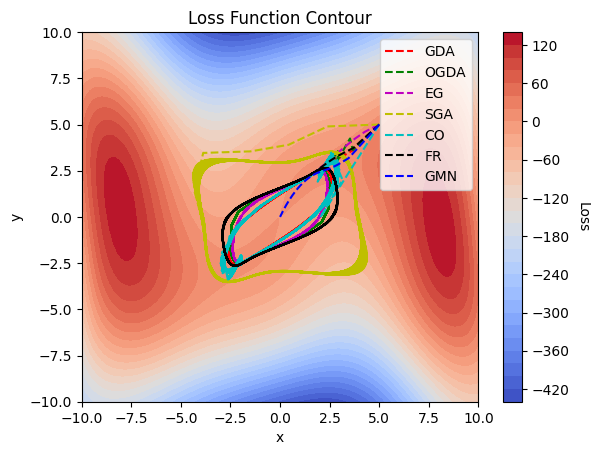

In [105]:
import matplotlib.pyplot as plt
from matplotlib import cm

# Plot the loss function as contour and the path taken by each algorithm
X = np.linspace(xlims[0], xlims[1], 100)
Y = np.linspace(ylims[0], ylims[1], 100)
X, Y = np.meshgrid(X, Y)
Z = loss_function(X, Y)
fig, ax = plt.subplots(1, 1)
ax.contourf(X, Y, Z, 30, cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Loss Function Contour')

cbar = fig.colorbar(mappable=ax.contourf(X, Y, Z, 30, cmap=cm.coolwarm), ax=ax)
cbar.ax.set_ylabel('Loss', rotation=-90, va="bottom")

gda_vals = np.asarray(gda_vals)
ax.plot(gda_vals[:,0], gda_vals[:,1], 'r--', label='GDA')
ogda_vals = np.asarray(ogda_vals)
ax.plot(ogda_vals[:,0], ogda_vals[:,1], 'g--', label='OGDA')
eg_vals = np.asarray(eg_vals)
ax.plot(eg_vals[:,0], eg_vals[:,1], 'm--', label='EG')
sga_vals = np.asarray(sga_vals)
ax.plot(sga_vals[:,0], sga_vals[:,1], 'y--', label='SGA')
co_vals = np.asarray(co_vals)
ax.plot(co_vals[:,0], co_vals[:,1], 'c--', label='CO')
# usgd_vals = np.asarray(usgd_vals)
# ax.plot(usgd_vals[:,0], usgd_vals[:,1], 'w--', label='USGD')
fr_vals = np.asarray(fr_vals)
ax.plot(fr_vals[:,0], fr_vals[:,1], 'k--', label='FR')
# hgd_vals = np.asarray(hgd_vals)
# ax.plot(hgd_vals[:,0], hgd_vals[:,1], 'r', label='HGD')
gmn_vals = np.asarray(gmn_vals)
ax.plot(gmn_vals[:,0], gmn_vals[:,1], 'b--', label='GMN')

ax.set_xlim(xlims)
ax.set_ylim(ylims)
ax.legend()
plt.show()

# Plot convergence

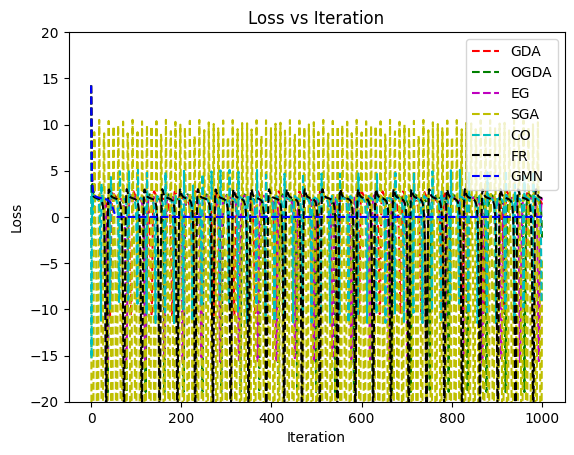

In [106]:
# Plot loss vs iteration for each algorithm in the same plot but different subplots
fig, ax = plt.subplots(1, 1)
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss')
ax.set_title('Loss vs Iteration')

ax.plot(gda_vals[:,2], 'r--', label='GDA')
ax.plot(ogda_vals[:,2], 'g--', label='OGDA')
ax.plot(eg_vals[:,2], 'm--', label='EG')
ax.plot(sga_vals[:,2], 'y--', label='SGA')
ax.plot(co_vals[:,2], 'c--', label='CO')
# ax.plot(usgd_vals[:,2], 'w--', label='USGD')
ax.plot(fr_vals[:,2], 'k--', label='FR')
# ax.plot(hgd_vals[:,2], 'r', label='HGD')
ax.plot(gmn_vals[:,2], 'b--', label='GMN')

ax.legend()
ax.set_ylim(-20, 20)
plt.show()